# Fast two-peak von Mises fit

The two-peak von Mises to fit to data points 
$$x = \begin{pmatrix}x_0\\ \vdots \\ x_{N-1}\end{pmatrix}$$ 
measured at uniformly distributed locations 
$$\varphi = \begin{pmatrix} \varphi_0 \\ \vdots \\ \varphi_{N-1} \end{pmatrix} \quad \varphi_k = \frac{2k\pi}{N}$$

is defined as 
$$ v = a_0 + a_1 g(\varphi) + a_2 g(\varphi-\pi)$$
where
$$g(\varphi) = e^{-w\left(1+\cos(\varphi - \theta)\right)}$$
The fit has five scalar parameters $a_0$, $a_1$, $a_2$, $w$, and $\theta$.



## Step 1. Remove offset and orthogonalize basis:
The least-squares fit will not be affected if both the data and the fitted functions have zero mean.  Subtracting the mean is a fast operation that does not affect the other parameters.  Therefore, let's modify the fitted functions as:
$$\dot g(\varphi) = g(\varphi) - \bar g$$ where $\bar g = \sum\limits_{k=0}^{N-1} g(\varphi_k)$ and fit the function 
$$v=a_1 \dot g(\varphi) + a_2 \dot g(\varphi-\pi) = a^\top G$$ with $$a=\begin{pmatrix}a_1 \\ a_2 \end{pmatrix}$$ and 
$$G = \begin{pmatrix} \dot g_1^\top(\varphi) \\ \dot g_2^\top(\varphi)\end{pmatrix}$$
to the data $\dot x_k = x_k-\bar x$ where $\bar x = \sum\limits_{k=0}^{N-1}x_k$.

The least squares fit is then $$\hat a = G^\dagger \dot x$$

The pseudo-inverse matrix $$G^\dagger(\theta, w)= \left(G G^\top \right)^{-1} G$$ is independent of $x$ and can be precomputed for a set of values of $w$ and $\theta$ to.

## Step 2: Optimize for preferred direction
Optimization for preferred direction is a convex problem when the sharpness is low or when the solution is close.  Therefore, we begin with low sharpness and optimize for preferred direction $\theta$ first and for sharpness $w$ simultaneous but at a slow conservative rate.

The initial estimate of $\theta$ can be computed quickly by measuring the circular mean of the doubled angle.  
$$\theta_0 = \tfrac 1 2 \arg \left(x^T e^{2 i \varphi}\right)$$
When the underlying data are well fitted with a 2-peak von Mises, this estimate will already approach the optimal value.  We will only assume that it is within 8$^\circ$ of the optimum and perform binary search.  Binary search with 1-degree precision will therefore take three steps.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from vonfit import von_mises2, fit_von_mises2, bootstrap_von_mises2

In [3]:
# model
N = 11   # number of directions
M = 50  # total number of trials   M >> N

theta = np.random.uniform(0,2*pi)
w = 6
a0 = 3.5
a1 = 2.0
a2 = 1.2

# data
phi = r_[0:2*pi:2*pi/N]
phi = np.concatenate((phi, np.random.choice(phi, M-N)))
sigma = 1.0
x = von_mises2(phi, a0, a1, a2, theta, w) + np.random.randn(*phi.shape)*sigma

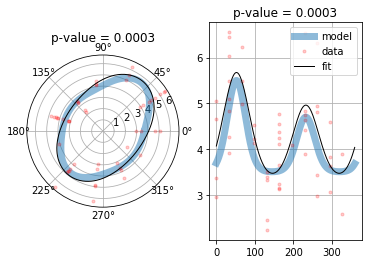

In [4]:
# plot fit results
t = r_[0:2*pi:pi/180]
polar = plt.subplot(121, projection='polar')
carte = plt.subplot(122)

polar.plot(t, von_mises2(t, a0, a1, a2, theta, w), lw=7, alpha=0.5)
carte.plot(t/pi*180, von_mises2(t, a0, a1, a2, theta, w), lw=7, alpha=0.5)
polar.plot(phi, x, '.', alpha=0.2, c='r')
carte.plot(phi/pi*180, x, '.', alpha=0.2, c='r')

polar.grid(True)
carte.grid(True)

v, r2, p = bootstrap_von_mises2(phi, x)
polar.plot(t, von_mises2(t, *v), lw=1, c='k')
carte.set_title('p-value = %g' % p)
carte.plot(t/pi*180, von_mises2(t, *v), lw=1, c='k')
polar.set_title('p-value = %g' % p)

carte.legend(('model', 'data', 'fit'));

In [5]:
%timeit fit_von_mises2(phi, x)

741 µs ± 8.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Example with real data

In [6]:
import datajoint as dj
dj.config['database.host'] = 'at-database'

In [7]:
tunemeso = dj.create_virtual_module('tunemeso', 'pfahey_tunemeso')
tune     = dj.create_virtual_module('tune', 'pipeline_tune')

Please enter DataJoint username: dimitri
Please enter DataJoint password: ········
Connecting dimitri@at-database:3306


In [8]:
key = {
    'animal_id':14864, 'session':1, 'scan_idx':16, 
    'segmentation_method':3, 'spike_method':5, 
    'unit_id':224}

In [9]:
x, phi = (tunemeso.Response.Trial()*tune.Drift.Trial() & key).fetch('response','direction')

In [10]:
v, r2, p = bootstrap_von_mises2(phi/180*pi, x)

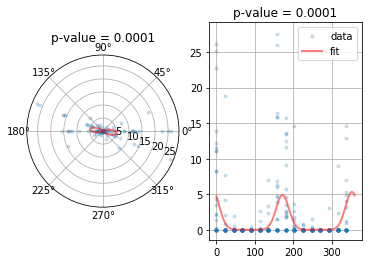

In [11]:
# plot fit results
t = r_[0:2*pi:pi/180]
polar = plt.subplot(121, projection='polar')
carte = plt.subplot(122)

polar.plot(phi/180*pi, x, '.', alpha=0.2)
carte.plot(phi, x, '.', alpha=0.2)

polar.grid(True)
carte.grid(True)

polar.plot(t, von_mises2(t, *v),  lw=2, c='r', alpha=0.5)
carte.set_title('p-value = %g' % p)
carte.plot(t/pi*180, von_mises2(t, *v), lw=2, c='r', alpha=0.5)
polar.set_title('p-value = %g' % p)

carte.legend(('data', 'fit'));